# DEFINIÇÃO DE ALGUMAS FUNÇÕES


1. linspace (ini, fim, pt): Separa o intervalo, incluindo o início e o fim, em um número de pontos igual a "pt";
2. np.full((x, y), p): Produz um array de dimensões X x Y, atribuindo o valor p aos seus pontos;
3. np.zeros ((x, y)): Produz um array de dimensões X x Y, atribuindo o valor 0.0 aos seus pontos;
4. np.reshape((y,x)): Produz um array de dimensões X x Y, sendo y a quantidade de linhas da matriz e x a quantidade de colunas. 



#BIBLIOTECAS A SEREM UTILIZADAS

In [1]:
import matplotlib.pyplot as plt
import math
import numpy as np
import numpy.matlib
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix, find
from scipy.sparse.linalg import spsolve
from scipy import linalg
from scipy.sparse.linalg import lsqr
from copy import deepcopy
import time
from tkinter import *

DEFINIÇÃO DE FUNÇÕES

In [2]:
def determinacao_B (DIRE_E_ATUAL, DIRE_n_ATUAL, X_ELEMENTO, Z_ELEMENTO):
  #===============================================================================================================
  #CÁLCULO DE "N" E "R"
  #===============================================================================================================
  N = np.array([((1 - DIRE_E_ATUAL)*(1 - DIRE_n_ATUAL))/4.0,\
      ((1 + DIRE_E_ATUAL)*(1 - DIRE_n_ATUAL))/4.0,\
      ((1 + DIRE_E_ATUAL)*(1 + DIRE_n_ATUAL))/4.0,\
      ((1 - DIRE_E_ATUAL)*(1 + DIRE_n_ATUAL))/4.0])
  r = np.dot( N, X_ELEMENTO )
  #===============================================================================================================
  #CÁLCULO DAS DERIVADAS DE "N" EM RELAÇÃO ÀS DIREÇÕES "n" e "E"
  #===============================================================================================================
  DERIV_N_DIRE_E_ATUAL = np.array([ -(1 - DIRE_n_ATUAL)/4.0, (1 - DIRE_n_ATUAL)/4.0,\
                          (1 + DIRE_n_ATUAL)/4.0, -(1 + DIRE_n_ATUAL)/4.0])
  DERIV_N_DIRE_n_ATUAL = np.array([ -(1 - DIRE_E_ATUAL)/4.0, -(1 + DIRE_E_ATUAL)/4.0,\
                          (1 + DIRE_E_ATUAL)/4.0, (1 - DIRE_E_ATUAL)/4.0])
  #===============================================================================================================
  #DETERMINAÇÃO DA MATRIZ JACOBIANA
  #===============================================================================================================
  JACOB = np.array( [ [ np.dot ( DERIV_N_DIRE_E_ATUAL, X_ELEMENTO ),\
            np.dot ( DERIV_N_DIRE_E_ATUAL, Z_ELEMENTO ) ],\
          [ np.dot ( DERIV_N_DIRE_n_ATUAL, X_ELEMENTO ),\
            np.dot ( DERIV_N_DIRE_n_ATUAL, Z_ELEMENTO)] ])
  JACOB_INV = linalg.inv(JACOB)
  #===============================================================================================================
  #CÁLCULO DAS DERIVADAS DE "N" EM RELAÇÃO ÀS DIREÇÕES "X" e "Z"
  #===============================================================================================================
  DERIV_N_X = np.array(JACOB_INV [ 0 ][ 0 ] * DERIV_N_DIRE_E_ATUAL + \
              JACOB_INV [ 0 ][ 1 ] * DERIV_N_DIRE_n_ATUAL)
  DERIV_N_Z = np.array(JACOB_INV [ 1 ][ 0 ] * DERIV_N_DIRE_E_ATUAL + \
              JACOB_INV [ 1 ][ 1 ] * DERIV_N_DIRE_n_ATUAL)
  #===============================================================================================================
  #DETERMINAÇÃO DA MATRIZ "B"
  #===============================================================================================================
  B = np.array([[DERIV_N_X [ 0 ], 0, DERIV_N_X [ 1 ], 0, DERIV_N_X [ 2 ], 0, DERIV_N_X [ 3 ], 0 ],\
      [0, DERIV_N_Z [ 0 ], 0, DERIV_N_Z [ 1 ], 0, DERIV_N_Z [ 2 ], 0, DERIV_N_Z [ 3 ] ],\
      [N [ 0 ] / r, 0, N [ 1 ] / r, 0, N [ 2 ] / r, 0, N [ 3 ] / r, 0 ],\
      [DERIV_N_Z [ 0 ], DERIV_N_X [ 0 ], DERIV_N_Z [ 1 ], DERIV_N_X [ 1 ],\
       DERIV_N_Z [ 2 ], DERIV_N_X [ 2 ], DERIV_N_Z [ 3 ], DERIV_N_X [ 3 ] ] ])
  return ( B, JACOB, r )

In [3]:
def graficos_contorno (figura, subfigura, x, z, resultado, unidade_resultado, titulo, unidade_x, unidade_z, niveis):
  contorno = plt.contourf(x, z, resultado, levels = niveis, cmap='jet')
  figura.colorbar(contorno, label = unidade_resultado, format='%.0e')
  subfigura.set_title (titulo)
  subfigura.set_xlabel (unidade_x)
  subfigura.set_ylabel (unidade_z)

# DETERMINAÇÃO DOS PARÂMETROS

In [4]:
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'axes.titlepad':20})
L = 2.0                                                             #TAMANHO X
NL = 501                                                             #NÚMERO DE PONTOS X
TM_INT = 1e-3
H = 0.5 + TM_INT                                                    #TAMANHO Z
NH = 501                                                            #NÚMRO DE PONTOS Z
ACAO = 2                                                            #TIPO DE AÇÃO APLICADA, 1 = FORCA, 2 = PRÉ-TENSAO, 3 = AMBOS
QT_TIPOS = 3                                                        #QUANTIDADE DE TIPOS DE MATERIAIS PRESENTES
TERMINO_TIPO_MATERIAL =  [0.3, 0.3 + TM_INT, 0.5 + TM_INT]          #POSIÇÃO FINAL Z PARA CADA TIPO DE MATERIAL
OPCAO = 1                                                           #OPÇÃO PARA DETERMINAR O COMPORTAMENTO DAS INTEGRINAS, 
if OPCAO != 1:                                                      #1 = MUDANÇA NA MATRIZ DE RIGIDEZ; 2 = MÓDULO DE ELAST. GRANDE
  MOD_ELAST_TIPO = [443e6, 0.9e12 , 0.9e9] 
else: 
  MOD_ELAST_TIPO =  [443e6, 0.9e12 , 0.9e9] 
  MOD_ELAST_INTEGRINA_PARALELO = 0.00001
COEF_POISSON_TIPO = [0.499, 0.499, 0.499]                              #COEFICIENTE DE POISSON DE CADA TIPO DE MATERIAL
VALOR_FORCA = 0.001                                                   #VALOR DA FORCA CONCENTRADA
DIRECAO_FORCA = 1                                                  #DIRECAO DE APLICACAO DA FORCA, 1 = r, 2 = z
NO_FORCA = 441                                                      #NÓ DE APLICAÇÃO DA FORCA
VALOR_PRE_TENSAO = -1000                                              #VALOR DA PRÉ-TENSAO
DIRECAO_PRE_TENSAO = 1                                              #DIRECAO DE APLICAÇÃO DA PRÉ-TENSÃO, 1 = r, 2 = z, 3 = t, 4 = rz
LIMITES_PRE_TENSAO = [0.3+TM_INT+(0.2/4.0) , 0.3+TM_INT+((0.2*2)/4.0)]  #POSICAO INICIAL E FINAL EM QUE A PRÉ-TENSÃO SERÁ APLICADA
NOS_CONTORNO = np.array(range(1,NL+1))                              #CONDIÇÕES DE CONTORNO EM RELAÇÃO A X E A Z

# GERAÇÃO DA MALHA

FORMAÇÃO DA MALHA ESTRUTURADA DE ELEMENTOS FINITOS, CRIAÇÃO DAS MATRIZES
DE CONECTIVIDADE E DE COORDENADAS.


In [5]:
#=====================================================================================================================
#DETERMINAÇÃO DE VARIÁVEIS A PARTIR DOS PARÂMETROS DEFINIDOS
#=====================================================================================================================
EL = NL - 1                                                         #NÚMERO DE ELEMENTOS POR LINHA
EH = NH - 1                                                         #NÚMERO DE ELEMENTOS POR COLUNA
NP = NL * NH                                                        #NÚMERO DE PONTOS NO TOTAL
NE = EL * EH                                                        #NÚMERO DE ELEMENTOS NO TOTAL
#=====================================================================================================================
#DEFINIÇÃO DOS PONTOS ENCONTRADOS NOS EIXOS X E Z
#=====================================================================================================================
X = np.concatenate (([0.0] , np.linspace ( 0 , L , NL )))
Z = np.concatenate (([0.0] , np.linspace ( 0 , H , NH )))
#=====================================================================================================================
#INICIALIZAÇÃO DAS MATRIZES DE CONECTIVIDADE E DE COORDENADAS
#=====================================================================================================================
mconect = np.full ( ( NE + 1, 4 ),0)
mcoord = np.zeros ( ( NP + 1, 2 ))
#=====================================================================================================================
#DETERMINAÇÃO DAS MATRIZES DE CONECTIVIDADE E DE COORDENADAS
#=====================================================================================================================
elemento = 1
linha_elementar = 1
while elemento <= NE:
  if elemento == 1:
    mconect [ elemento, : ] = [ 1 , 2 , NL + 2 , NL + 1 ]
    mcoord [ mconect [ elemento, : ], 0 ] = [ X [ 1 ], X [ 2 ], X [ 2 ], X [ 1 ] ]
    mcoord [ mconect [ elemento, : ], 1 ] = [ Z [ 1 ], Z [ 1 ], Z [ 2 ], Z [ 2 ] ]

  elif elemento <= EL:
    mconect [ elemento ] [ : ] = [ mconect [ elemento - 1, 1 ], mconect [ elemento - 1, 1 ] + 1, \
                                  mconect [ elemento - 1, 2 ] + 1 , mconect [ elemento - 1, 2 ] ]     
    mcoord [ mconect [ elemento, 1:3 ], 0 ] = [ X [ mconect [ elemento, 1 ] ], X [ mconect [ elemento, 1 ] ] ]
    mcoord [ mconect [ elemento , 1:3 ], 1 ] = [ Z [ 1 ], Z [ 2 ] ]

  elif elemento == ( ( linha_elementar - 1 ) * EL ) + 1:
    mconect [ elemento ] [ : ] = [ mconect [ elemento - EL ] [ 3 ], mconect [ elemento - EL ] [ 2 ], \
                                  mconect [ elemento - 1 ] [ 2 ] + 2 , mconect [ elemento - 1 ] [ 2 ] + 1 ]
    mcoord [ mconect [ elemento, 2:4 ], 0 ] = [ X [ 2 ], X [ 1 ] ]
    mcoord [ mconect [ elemento, 2:4 ], 1 ] = [ Z [ linha_elementar + 1 ], Z [ linha_elementar + 1 ] ]

  else:
    mconect [ elemento ] [ : ] = [ mconect [ elemento - 1, 1 ], mconect [ elemento - EL, 2 ], \
                                  mconect [ elemento - 1, 2 ] + 1 , mconect [ elemento - 1, 2 ] ]
    mcoord [ mconect [ elemento, 2 ], 0:2 ] = [ mcoord [ mconect [ elemento - EL , 2 ], 0 ],\
                                               Z [ linha_elementar + 1 ] ]
  if elemento == EL * linha_elementar:
    linha_elementar += 1
  elemento += 1

# CÁLCULO DA MATRIZ DE RIGIDEZ

FORMULAÇÃO DOS ELEMENTOS


In [6]:
#=====================================================================================================================
#FORMAÇÃO DAS MATRIZES X_ELEMENTOS E Z_ELEMENTOS, CORRESPONDENTES A: 
#X=[[0,0,0,0],[x1, x2, x3, x4], ...] E Z=[[0,0,0,0], [z1, z2, z3, z4], ...]
#=====================================================================================================================
X_ELEMENTOS = []
Z_ELEMENTOS = []
X_ELEMENTOS.append (np.array([0,0,0,0]))
Z_ELEMENTOS.append (np.array([0,0,0,0]))
for elemento in mconect[1:]:
  NO_X = []
  NO_Z = []
  for no in elemento:
    NO_X.append (mcoord[no][0])
    NO_Z.append (mcoord[no][1])
  X_ELEMENTOS.append (np.array (NO_X))
  Z_ELEMENTOS.append (np.array (NO_Z))
X_ELEMENTOS = np.array (X_ELEMENTOS)
Z_ELEMENTOS = np.array (Z_ELEMENTOS)

DETERMINAÇÃO DOS MÓDULOS DE ELASTICIDADE E POISSON

In [7]:
#=====================================================================================================================
#DETERMINAÇÃO DOS ELEMENTOS CONTIDOS DENTRO DE CADA MATERIAL
#=====================================================================================================================
ELEMENTO_LIMITE_TIPO = [0] * QT_TIPOS;
ESPACAMENTO = H / EH;
for TIPO in range(0,  QT_TIPOS):
  QT_ELEMENTOS_ATE_LIMITE = TERMINO_TIPO_MATERIAL [TIPO] / ESPACAMENTO
  if (abs(QT_ELEMENTOS_ATE_LIMITE - math.floor(QT_ELEMENTOS_ATE_LIMITE) ) >= 0.5):
    ELEMENTO_LIMITE_TIPO [TIPO] = round(QT_ELEMENTOS_ATE_LIMITE) * EL
  else:
    ELEMENTO_LIMITE_TIPO [TIPO] = math.floor(QT_ELEMENTOS_ATE_LIMITE) * EL
#=====================================================================================================================
#DETERMINAÇÃO DO TIPO DE MATERIAL CORRESPONDENTE PARA CADA ELEMENTO
#=====================================================================================================================
ATUAL = 1
TIPO_MATERIAL = [0]*(NE  + 1)
for TIPO in range(len(ELEMENTO_LIMITE_TIPO)):
  ELEMENTO_LIMITE = ELEMENTO_LIMITE_TIPO [TIPO]
  for ELEMENTO in range (ATUAL, ELEMENTO_LIMITE + 1):
    TIPO_MATERIAL [ELEMENTO] = TIPO
    ATUAL = ATUAL + 1
#=====================================================================================================================
#DETERMINAÇÃO DAS PROPRIEDADES DE CADA TIPO DE ELEMENTO
#===================================================================================================================== 
MOD_ELAST = []
COEF_POISSON = []
for tipo in TIPO_MATERIAL:
  MOD_ELAST.append ( MOD_ELAST_TIPO [ tipo ] )
  COEF_POISSON.append ( COEF_POISSON_TIPO [ tipo ] )
MOD_ELAST = np.array (MOD_ELAST)
COEF_POISSON = np.array (COEF_POISSON)
#=====================================================================================================================
#INICIALIZAÇÃO DA FORÇA APLICADA
#===================================================================================================================== 
FORCA = [0.0]*(2*NP)
if (ACAO != 2):
  if (DIRECAO_FORCA == 2):
    FORCA [ NO_FORCA * 2 - 1 ] = VALOR_FORCA
  else:
    FORCA [ NO_FORCA * 2 ] = VALOR_FORCA
ELEMENTO_LIMITE_PRE_TENSAO = []
#=====================================================================================================================
#DETERMINAÇÃO DOS ELEMENTOS DA PRÉ-TENSAO
#===================================================================================================================== 
if (ACAO != 1):
  for LIMITES in LIMITES_PRE_TENSAO:
    QT_ELEMENTOS_ATE_LIMITE = LIMITES/ESPACAMENTO
    if (abs(QT_ELEMENTOS_ATE_LIMITE - math.floor(QT_ELEMENTOS_ATE_LIMITE) ) >= 0.5):
      ELEMENTO_LIMITE_PRE_TENSAO.append (round(QT_ELEMENTOS_ATE_LIMITE) * EL)
    else:
      ELEMENTO_LIMITE_PRE_TENSAO.append (math.floor (QT_ELEMENTOS_ATE_LIMITE) * EL)
  ELEMENTO_LIMITE_PRE_TENSAO[0]=ELEMENTO_LIMITE_PRE_TENSAO[0]+1

In [8]:
print (ELEMENTO_LIMITE_TIPO[1])

150000


In [9]:
#=====================================================================================================================
#PLOT DA MALHA GERADA
#=====================================================================================================================
#divisoes = np.zeros ((EL, EH))
#divisoes [ ( ( ELEMENTO_LIMITE_TIPO [ 0 ] // EH ) + 1  ) : \
#            ( ( ELEMENTO_LIMITE_TIPO [ 1 ] // EH ) + 1  )  , :] = 5
#fig, malha = plt.subplots()
#malha.pcolormesh(X [1: ], Z [1:], divisoes, shading='flat', cmap = 'Greens', vmin=divisoes.min(), vmax=divisoes.max())
#X_M , Z_M = np.meshgrid (X[1:], Z[1:])
#malha.plot (X_M, Z_M, 'x', color = 'green')
#malha.set_title('Malha Elementos Finitos')
#plt.show()

DETERMINAÇÃO DA MATRIZ DE RIGIDEZ

In [10]:
#=====================================================================================================================
#INICIALIZAÇÃO DA MATRIZ DE RIGIDEZ GLOBAL(K)
#=====================================================================================================================
#K_GLOBAL = np.zeros((2 * NP, 2 * NP ))
K_GERAL = [0] * 64 * NE
#=====================================================================================================================
#CÁLCULO DA MATRIZ DE RIGIDEZ (K) UTILIZANDO QUADRATURA GAUSSIANA
#=====================================================================================================================
VALOR = 1.0/math.sqrt(3.0)
DIRE_E = np.array([ -VALOR , VALOR , VALOR, -VALOR ])
DIRE_n = np.array([ -VALOR , -VALOR , VALOR, VALOR ])
contador = 0 
if (ACAO != 1):
  FORCA_GERAL = [0] * 8 * NE
#=====================================================================================================================
#DETERMINAÇÃO DA MATRIZ DE RIGIDEZ E DA FORÇA NO CASO DA APLICAÇÃO DE UMA PRÉ-TENSÃO
#=====================================================================================================================
for elemento in range (1, NE + 1):
  #=================================================================================================================
  #MATRIZ CONSTITUTIVA (D) PARA MATERIAL ISOTRÓPICO
  #OBS.: [D]=[4]X[4]
  #=================================================================================================================
  CPE = COEF_POISSON [ elemento ]
  D = np.array ( [ [1.0 - CPE, CPE, CPE, 0.0],\
        [CPE, 1.0 - CPE, CPE, 0.0],\
        [CPE, CPE, 1.0 - CPE, 0.0],\
        [0.0, 0.0, 0.0, ( 1.0 - ( 2.0 * CPE) ) / 2.0 ] ] )
  D = D * (MOD_ELAST [ elemento ] / ( ( 1 + CPE ) * ( 1 - ( 2 * CPE ) ) ))
  #=================================================================================================================
  #INICIALIZAÇÃO DA MATRIZ DE RIGIDEZ (K)
  #=================================================================================================================
  K = np.zeros((8,8))
  if (ACAO != 1):
    FORCA_LOCAL = [0] * 8
    PRE_TENSAO_NO = np.array([0] * 4)
    if (elemento >= ELEMENTO_LIMITE_PRE_TENSAO [0] and elemento <= ELEMENTO_LIMITE_PRE_TENSAO [1]):
      PRE_TENSAO_NO [:] = [1, 1, 1, 1]
  for p in range (0,4):
    #===============================================================================================================
    #DETERMINAÇÃO DA MATRIZ "B"
    #===============================================================================================================
    B, JACOB, r = determinacao_B (DIRE_E [p], DIRE_n [p], X_ELEMENTOS [ elemento ], Z_ELEMENTOS [ elemento ])
    #===============================================================================================================
    #DETERMINAÇÃO DA MATRIZ DE RIGIDEZ "K" LOCAL
    #===============================================================================================================
    K = K + (2 * np.pi * ((B.T).dot (D)).dot (B) * linalg.det (JACOB) * r)
    if ( OPCAO == 1 and TIPO_MATERIAL [ elemento ] == 1 ):
      K_AUX = K [:][:]
      K = np.full ((8,8), MOD_ELAST_INTEGRINA_PARALELO)
      pos = [[0,6], [6,0], [2,4], [4,2], [7,1], [1,7], [3,5], [5,3]]
      for i in pos:
        K [ i [ 0 ] ][ i [ 1 ] ] = K_AUX [ i [ 0 ] ][ i [ 1 ] ]
    #===============================================================================================================
    #DETERMINAÇÃO DA FORÇA NO CASO DA APLICAÇÃO DE PRÉ-TENSÃO
    #===============================================================================================================
    if (ACAO != 1):
      SIGMA_ZERO = [0]*4
      if (PRE_TENSAO_NO [p] > 0):
        SIGMA_ZERO [DIRECAO_PRE_TENSAO - 1] = VALOR_PRE_TENSAO
      FORCA_LOCAL = FORCA_LOCAL - (2 * np.pi * (B.T).dot(SIGMA_ZERO) * linalg.det (JACOB) * r)
  #===============================================================================================================
  #DETERMINAÇÃO DA MATRIZ DE RIGIDEZ "K" GLOBAL
  #===============================================================================================================
  K = np.resize ( K, ( 64 ) ) 
  FORCA_LOCAL = np.resize ( FORCA_LOCAL, ( 8 ) )
  K_GERAL [ ( elemento - 1 ) * 64 : elemento * 64 ] = K
  FORCA_GERAL [ ( elemento - 1 ) * 8 : elemento * 8 ] = FORCA_LOCAL
graus_liberdade = np.kron( mconect [1: ], [ 1 , 1 ] )* 2 - np.matlib.repmat([2, 1], NE ,4)
pos_global_ik = np.reshape ( np.kron (graus_liberdade, [1] * 8 ), 64 * NE )
pos_global_jk = np.reshape ( np.kron (graus_liberdade, [[1]] * 8 ), 64 * NE )
K_GLOBAL = csr_matrix (( K_GERAL, (pos_global_ik, pos_global_jk)))
pos_global_if = np.reshape (graus_liberdade, 8 * NE ) 
pos_global_jf = np.full ((8 * NE), 0)
FORCA = csr_matrix ((FORCA_GERAL, (pos_global_if, pos_global_jf)))
FORCA.eliminate_zeros()

# DETERMINAÇÃO DO DESLOCAMENTO 

DETERMINAÇÃO DOS DESLOCAMENTOS

In [11]:
#=====================================================================================================================
#TRANSFORMAÇÃO DOS NÓS PARA GRAUS DE LIBERDADE DE ACORDO COM A ORIENTAÇÃO
#=====================================================================================================================
GRAUS_CONTORNO = np.kron( NOS_CONTORNO , [ 1 , 1 ] )* 2 - np.reshape ( np.matlib.repmat([2, 1], NL , 1 ), 2 * NL )
#=====================================================================================================================
#ADIÇÃO DAS CONDIÇÕES DE CONTORNO NA MATRIZ DE RIGIDEZ
#=====================================================================================================================
K_GLOBAL = K_GLOBAL.tolil ()
for grau in GRAUS_CONTORNO:
  K_GLOBAL [ grau, : ] = 0
  K_GLOBAL [ :, grau ] = 0
  K_GLOBAL [ grau, grau ] = 1
K_GLOBAL = K_GLOBAL.tocsr ()
K_GLOBAL.eliminate_zeros()

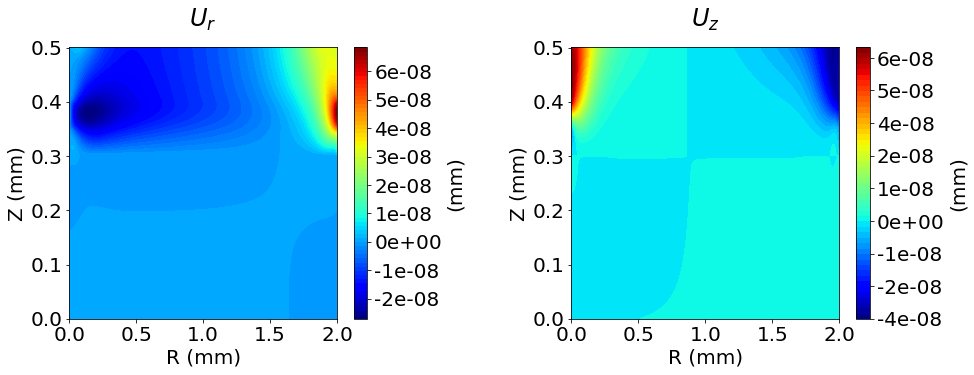

In [12]:
#=====================================================================================================================
#RESOLUÇÃO DO SISTEMA 
#=====================================================================================================================
DESLOCAMENTOS = spsolve (K_GLOBAL, FORCA)
#=====================================================================================================================
#PLOT DOS DESLOCAMENTOS
#=====================================================================================================================
X_RESULTADO, Z_RESULTADO = np.meshgrid(X[1:], Z[1:])
U_X, U_Z= [DESLOCAMENTOS[i::2] for i in range(2)]
U_X_PLOT = np.reshape ( U_X, (NH, NL))
U_Z_PLOT = np.reshape ( U_Z, (NH, NL))

fig = plt.figure (figsize=(15,5))

desloc_x = fig.add_subplot ( 121 )
graficos_contorno (fig, desloc_x, X[1:], Z[1:], U_X_PLOT, "(mm)", "$U_r$", "R (mm)", "Z (mm)", 90)

desloc_z = fig.add_subplot ( 122 )
graficos_contorno (fig, desloc_z, X[1:], Z[1:], U_Z_PLOT, "(mm)", "$U_z$", "R (mm)", "Z (mm)", 50)

plt.subplots_adjust(wspace=0.5, hspace=0.8)
plt.show()

#DETERMINAÇÃO DAS DEFORMAÇÕES E TENSÕES

DETERMINAÇÃO DOS DESLOCAMENTOS NOS ELEMENTOS

Text(0, 0.5, '(mm)')

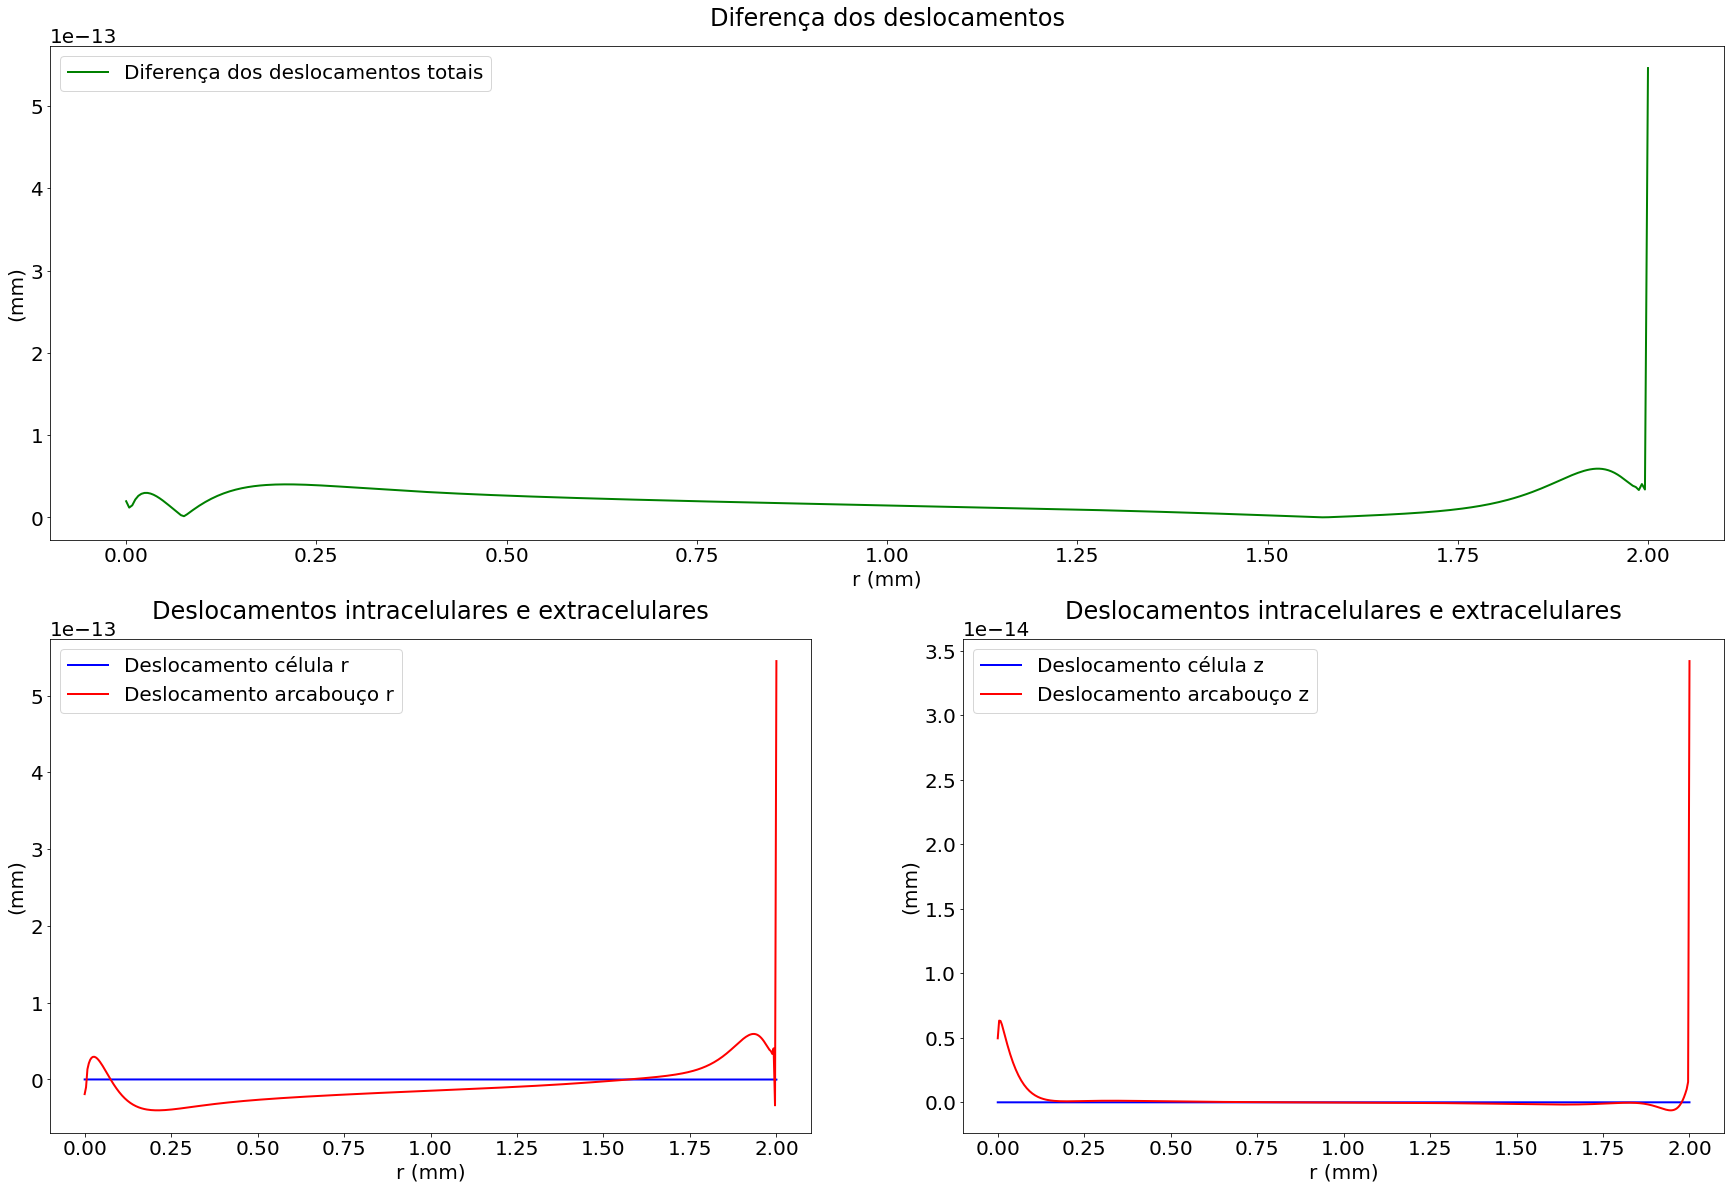

In [13]:
U_ELEMENTO = []
DESLOCAMENTO_CELULA_R = np.zeros (NL)
DESLOCAMENTO_ARCABOUCO_R = np.zeros (NL)
DESLOCAMENTO_CELULA_Z = np.zeros (NL)
DESLOCAMENTO_ARCABOUCO_Z = np.zeros (NL)
numero_elemento = 1
ponto_linha_abaixo = 0
ponto_linha_acima = 0
linha =  1          #2 PARA A SEGUNDA LINHA APÓS A INTEGRINA
for elemento_in in mconect [1:]:
  AUX_ELEMENTO = []
  contador = 1
  elemento = [ elemento_in [ 0 ], elemento_in [ 1 ], elemento_in [ 3 ], elemento_in [ 2 ] ]
  for no in elemento:
    if numero_elemento > ( ELEMENTO_LIMITE_TIPO [ 0 ] - linha * EL ) and \
                           numero_elemento <= ( ELEMENTO_LIMITE_TIPO [0] - (linha - 1 ) * EL ):
      if numero_elemento == ( ELEMENTO_LIMITE_TIPO [ 0 ] - linha * EL + 1 ) and contador == 3:
        DESLOCAMENTO_ARCABOUCO_R [ ponto_linha_abaixo ] = DESLOCAMENTOS [(no * 2 - 2)]
        DESLOCAMENTO_ARCABOUCO_Z [ ponto_linha_abaixo ] = DESLOCAMENTOS [(no * 2 - 1)]
        ponto_linha_abaixo += 1
      if contador == 4:
        DESLOCAMENTO_ARCABOUCO_R [ ponto_linha_abaixo ] = DESLOCAMENTOS [(no * 2 - 2)]
        DESLOCAMENTO_ARCABOUCO_Z [ ponto_linha_abaixo ] = DESLOCAMENTOS [(no * 2 - 1)]
        ponto_linha_abaixo += 1
    linha -= 1
    if numero_elemento > ( ELEMENTO_LIMITE_TIPO [ 1 ] + linha * EL )  and \
                           numero_elemento <= ( ELEMENTO_LIMITE_TIPO [1] + (linha + 1) * EL ):
      if numero_elemento == ( ELEMENTO_LIMITE_TIPO [ 1 ] + linha * EL + 1 ) and contador == 1:
        DESLOCAMENTO_CELULA_R [ ponto_linha_acima ] = DESLOCAMENTOS [(no * 2 - 2)]
        DESLOCAMENTO_CELULA_Z [ ponto_linha_acima ] = DESLOCAMENTOS [(no * 2 - 1)]
        ponto_linha_acima += 1
      if contador == 2:
        DESLOCAMENTO_CELULA_R [ ponto_linha_acima ] = DESLOCAMENTOS [(no * 2 - 2)]
        DESLOCAMENTO_CELULA_Z [ ponto_linha_acima ] = DESLOCAMENTOS [(no * 2 - 1)]
        ponto_linha_acima += 1
    linha += 1
    #no_ordenado = elemento_in [ contador - 1 ]
    #AUX_ELEMENTO.append (DESLOCAMENTOS [(no_ordenado * 2 - 2)])
    #AUX_ELEMENTO.append (DESLOCAMENTOS [(no_ordenado * 2 - 1)])
    contador += 1
  #U_ELEMENTO.append (np.array(AUX_ELEMENTO))
  numero_elemento += 1
for elemento in mconect [1:]:
  AUX_ELEMENTO = []
  for no in elemento:
    AUX_ELEMENTO.append (DESLOCAMENTOS [(no * 2 - 2)])
    AUX_ELEMENTO.append (DESLOCAMENTOS [(no * 2 - 1)])
  U_ELEMENTO.append (np.array(AUX_ELEMENTO))
DIFERENCA_DESLOCAMENTO = np.sqrt ((DESLOCAMENTO_CELULA_R - DESLOCAMENTO_ARCABOUCO_R)**2 + \
                         (DESLOCAMENTO_CELULA_Z - DESLOCAMENTO_ARCABOUCO_Z)**2)
#=====================================================================================================================
#PLOT DOS DESLOCAMENTOS DE INTERESSE
#=====================================================================================================================
figura = plt.figure (figsize=(30,20))

desloc_auddya = figura.add_subplot ( 211 )
desloc_auddya.plot ( X [1:] , DIFERENCA_DESLOCAMENTO , c = 'g', lw = 2, ls = '-' , label = \
                    "Diferença dos deslocamentos totais")
desloc_auddya.legend ( loc = "upper left" )
desloc_auddya.set_title ("Diferença dos deslocamentos")
desloc_auddya.set_xlabel ( "r (mm)" )
desloc_auddya.set_ylabel ( "(mm)" )

desloc_auddya_r = figura.add_subplot ( 223 )
desloc_auddya_r.plot ( X [1:] , DESLOCAMENTO_CELULA_R, c = 'b' , linewidth = 2, linestyle = '-', \
                    label = "Deslocamento célula r" )
desloc_auddya_r.plot ( X [1:] , DESLOCAMENTO_ARCABOUCO_R, c = 'r' , lw = 2, ls = '-' , \
                    label = "Deslocamento arcabouço r" )
desloc_auddya_r.legend ( loc = "upper left" )
desloc_auddya_r.set_title ("Deslocamentos intracelulares e extracelulares")
desloc_auddya_r.set_xlabel ( "r (mm)" )
desloc_auddya_r.set_ylabel ( "(mm)" )

desloc_auddya_z = figura.add_subplot ( 224 )
desloc_auddya_z.plot ( X [1:] , DESLOCAMENTO_CELULA_Z, c = 'b' , linewidth = 2, linestyle = '-', \
                    label = "Deslocamento célula z" )
desloc_auddya_z.plot ( X [1:] , DESLOCAMENTO_ARCABOUCO_Z, c = 'r' , lw = 2, ls = '-' , \
                    label = "Deslocamento arcabouço z" )
desloc_auddya_z.legend ( loc = "upper left" )
desloc_auddya_z.set_title ("Deslocamentos intracelulares e extracelulares")
desloc_auddya_z.set_xlabel ( "r (mm)" )
desloc_auddya_z.set_ylabel ( "(mm)" )


CÁLCULO DAS DEFORMAÇÕES E TENSÕES A PARTIR DOS DESLOCAMENTOS
- Pontos de Gauss

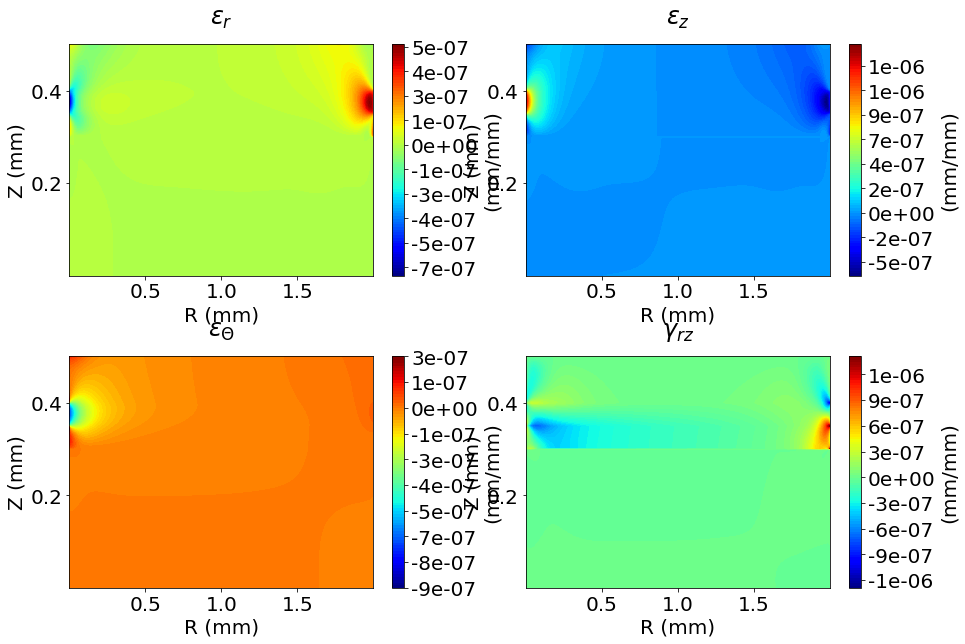

In [14]:
DIRE_E = np.array([ -VALOR, VALOR, VALOR, -VALOR])
DIRE_n = np.array([ -VALOR, -VALOR, VALOR, VALOR])
DEFORMACAO = []
TENSAO = []
for elemento in range (1, NE + 1):
  DEFORMACAO_ELEMENTO = []
  TENSAO_ELEMENTO = []
  #=====================================================================================================================
  #MATRIZ CONSTITUTIVA (D) PARA MATERIAL ISOTRÓPICO
  #OBS.: [D]=[4]X[4]
  #=====================================================================================================================
  CPE = COEF_POISSON [ elemento ]
  D = np.array ( [ [1.0 - CPE, CPE, CPE, 0.0],\
        [CPE, 1.0 - CPE, CPE, 0.0],\
        [CPE, CPE, 1.0 - CPE, 0.0],\
        [0.0, 0.0, 0.0, ( 1.0 - ( 2.0 * CPE) ) / 2.0 ] ] )
  D = D * (MOD_ELAST [ elemento ] / ( ( 1 + CPE ) * ( 1 - ( 2 * CPE ) ) ))
  for p in range (0,4):
    #=================================================================================================================
    #DETERMINAÇÃO DA MATRIZ "B"
    #=================================================================================================================
    B, JACOB, r = determinacao_B (DIRE_E [p], DIRE_n [p], X_ELEMENTOS [ elemento ], Z_ELEMENTOS [ elemento ])
    DEFORMACAO_PONTO = np.dot (B, U_ELEMENTO[elemento-1])
    TENSAO_PONTO = np.dot ( D, DEFORMACAO_PONTO)
    DEFORMACAO_ELEMENTO.append (DEFORMACAO_PONTO)
    TENSAO_ELEMENTO.append (TENSAO_PONTO)
  DEFORMACAO.append (DEFORMACAO_ELEMENTO)
  TENSAO.append (TENSAO_ELEMENTO)
DEFORMACAO = np.array ( DEFORMACAO )
TENSAO = np.array ( TENSAO )  

DEFORMACAO_R_ELEMENTO = DEFORMACAO [:, :, 0]
DEFORMACAO_Z_ELEMENTO = DEFORMACAO [:, :, 1]
DEFORMACAO_THETA_ELEMENTO = DEFORMACAO [:, :, 2]
DEFORMACAO_RZ_ELEMENTO = DEFORMACAO [:, :, 3]

TENSAO_R_ELEMENTO = TENSAO [:, :, 0]
TENSAO_Z_ELEMENTO = TENSAO [:, :, 1]
TENSAO_THETA_ELEMENTO = TENSAO [:, :, 2]
TENSAO__RZ_ELEMENTO = TENSAO [:, :, 3]
#print (DEFORMACAO[319])
#===================================================================================================================
#PLOT DAS TENSÕES E DEFORMAÇÕES
#===================================================================================================================
GAUSS_X = ((X[2]-X[1])*(1.0/math.sqrt(3.0)))/2
GAUSS_Z = ((Z[2]-Z[1])*(1.0/math.sqrt(3.0)))/2
X_TENSAO_DEFORMACAO = []
Z_TENSAO_DEFORMACAO = []
DEFORMACAO_SEQUENCIAL = []
TENSAO_SEQUENCIAL = []
ATUAL_Z = (Z[2]-Z[1])/2.0
for MULTIPLICADOR in range (1, ( EH + 1)):
  INICIAL = ((MULTIPLICADOR - 1) * EL)  + 1
  FINAL = MULTIPLICADOR * EL
  DEFORMACAO_SEQUENCIAL_AUX_1 = []
  TENSAO_SEQUENCIAL_AUX_1 = []
  DEFORMACAO_SEQUENCIAL_AUX_2 = []
  TENSAO_SEQUENCIAL_AUX_2 = []
  ATUAL_X = (X[2]-X[1])/2.0
  for elemento in range (INICIAL, FINAL + 1):
    if MULTIPLICADOR == 1:
      X_TENSAO_DEFORMACAO.append (ATUAL_X-GAUSS_X)
      X_TENSAO_DEFORMACAO.append (ATUAL_X+GAUSS_X)
    if elemento == INICIAL:
      Z_TENSAO_DEFORMACAO.append (ATUAL_Z-GAUSS_Z)
      Z_TENSAO_DEFORMACAO.append (ATUAL_Z+GAUSS_Z)
    DEFORMACAO_SEQUENCIAL_AUX_1.append (DEFORMACAO [elemento - 1, 0, :])
    DEFORMACAO_SEQUENCIAL_AUX_1.append (DEFORMACAO [elemento - 1, 1, :])
    DEFORMACAO_SEQUENCIAL_AUX_2.append (DEFORMACAO [elemento - 1, 3, :])
    DEFORMACAO_SEQUENCIAL_AUX_2.append (DEFORMACAO [elemento - 1, 2, :])
    TENSAO_SEQUENCIAL_AUX_1.append (TENSAO [elemento - 1, 0, :])
    TENSAO_SEQUENCIAL_AUX_1.append (TENSAO [elemento - 1, 1, :])
    TENSAO_SEQUENCIAL_AUX_2.append (TENSAO [elemento - 1, 3, :])
    TENSAO_SEQUENCIAL_AUX_2.append (TENSAO [elemento - 1, 2, :])
    ATUAL_X = ATUAL_X + (X[2]-X[1])
  ATUAL_Z = ATUAL_Z + (Z[2]-Z[1])
  DEFORMACAO_SEQUENCIAL.append (DEFORMACAO_SEQUENCIAL_AUX_1)
  DEFORMACAO_SEQUENCIAL.append (DEFORMACAO_SEQUENCIAL_AUX_2)
  TENSAO_SEQUENCIAL.append (TENSAO_SEQUENCIAL_AUX_1)
  TENSAO_SEQUENCIAL.append (TENSAO_SEQUENCIAL_AUX_2)
DEFORMACAO_SEQUENCIAL = np.array (DEFORMACAO_SEQUENCIAL)
TENSAO_SEQUENCIAL = np.array (TENSAO_SEQUENCIAL)
X_TENSAO_DEFORMACAO = np.array (X_TENSAO_DEFORMACAO)
Z_TENSAO_DEFORMACAO = np.array (Z_TENSAO_DEFORMACAO)
DEFORMACAO_R_SEQ = DEFORMACAO_SEQUENCIAL [ : , :, 0]
DEFORMACAO_Z_SEQ = DEFORMACAO_SEQUENCIAL [ : , :, 1]
DEFORMACAO_THETA_SEQ = DEFORMACAO_SEQUENCIAL [ : , : , 2]
DEFORMACAO_RZ_SEQ = DEFORMACAO_SEQUENCIAL [ : , :, 3]

X_RESULTADO_DEFORM, Z_RESULTADO_DEFORM = np.meshgrid(X_TENSAO_DEFORMACAO, Z_TENSAO_DEFORMACAO)

fig2 = plt.figure (figsize=(15,10))

deform_x = fig2.add_subplot ( 221 )
graficos_contorno (fig2, deform_x, X_RESULTADO_DEFORM, Z_RESULTADO_DEFORM, DEFORMACAO_R_SEQ, \
                   "(mm/mm)", "$\epsilon_r$", "R (mm)" , "Z (mm)", 90)

deform_z = fig2.add_subplot ( 222 )
graficos_contorno (fig2, deform_z, X_RESULTADO_DEFORM, Z_RESULTADO_DEFORM, DEFORMACAO_Z_SEQ, \
                   "(mm/mm)", "$\epsilon_z$", "R (mm)" , "Z (mm)", 90)

deform_t = fig2.add_subplot ( 223 )
graficos_contorno (fig2, deform_t, X_RESULTADO_DEFORM, Z_RESULTADO_DEFORM, DEFORMACAO_THETA_SEQ, \
                   "(mm/mm)", "$\epsilon_\Theta$", "R (mm)" , "Z (mm)", 90)

deform_rz = fig2.add_subplot ( 224 )
graficos_contorno (fig2, deform_rz, X_RESULTADO_DEFORM, Z_RESULTADO_DEFORM, DEFORMACAO_RZ_SEQ, \
                   "(mm/mm)", "$\gamma_{rz}$", "R (mm)" , "Z (mm)", 90)

plt.subplots_adjust(wspace=0.2, hspace=0.35)
plt.show()

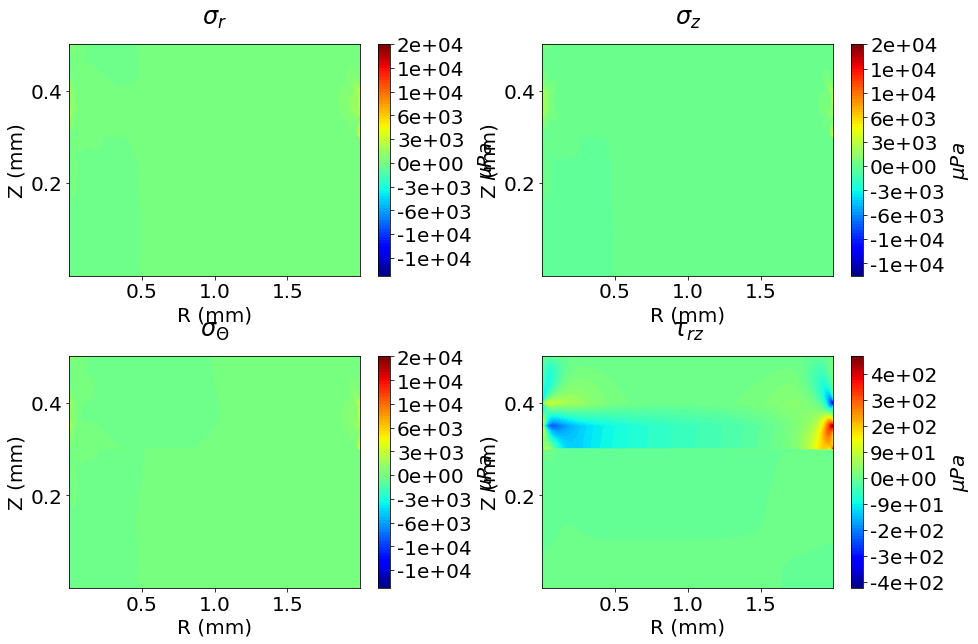

In [15]:
TENSAO_R_SEQ = TENSAO_SEQUENCIAL [ : , :, 0]
TENSAO_Z_SEQ = TENSAO_SEQUENCIAL [ : , :, 1]
TENSAO_THETA_SEQ = TENSAO_SEQUENCIAL [ : , : , 2]
TENSAO_RZ_SEQ = TENSAO_SEQUENCIAL [ : , :, 3]
X_RESULTADO_TENSAO, Z_RESULTADO_TENSAO = np.meshgrid(X_TENSAO_DEFORMACAO, Z_TENSAO_DEFORMACAO)

fig3 = plt.figure (figsize=(15,10))
tensao_x = fig3.add_subplot ( 221 )
graficos_contorno (fig3, tensao_x, X_RESULTADO_TENSAO, Z_RESULTADO_TENSAO, TENSAO_R_SEQ, \
                   "$\mu Pa$", "$\sigma_r$", "R (mm)" , "Z (mm)", 90)

tensao_z = fig3.add_subplot ( 222 )
graficos_contorno (fig3, tensao_z, X_RESULTADO_TENSAO, Z_RESULTADO_TENSAO, TENSAO_Z_SEQ, \
                   "$\mu Pa$", "$\sigma_z$", "R (mm)" , "Z (mm)", 90)

tensao_t = fig3.add_subplot ( 223 )
graficos_contorno (fig3, tensao_t, X_RESULTADO_TENSAO, Z_RESULTADO_TENSAO, TENSAO_THETA_SEQ, \
                   "$\mu Pa$", "$\sigma_\Theta$", "R (mm)" , "Z (mm)", 90)

tensao_rz = fig3.add_subplot ( 224 )
graficos_contorno (fig3, tensao_rz, X_RESULTADO_TENSAO, Z_RESULTADO_TENSAO, TENSAO_RZ_SEQ, \
                   "$\mu Pa$", "$\\tau_{rz}$", "R (mm)" , "Z (mm)", 90)

plt.subplots_adjust(wspace=0.3, hspace=0.35)
plt.show()

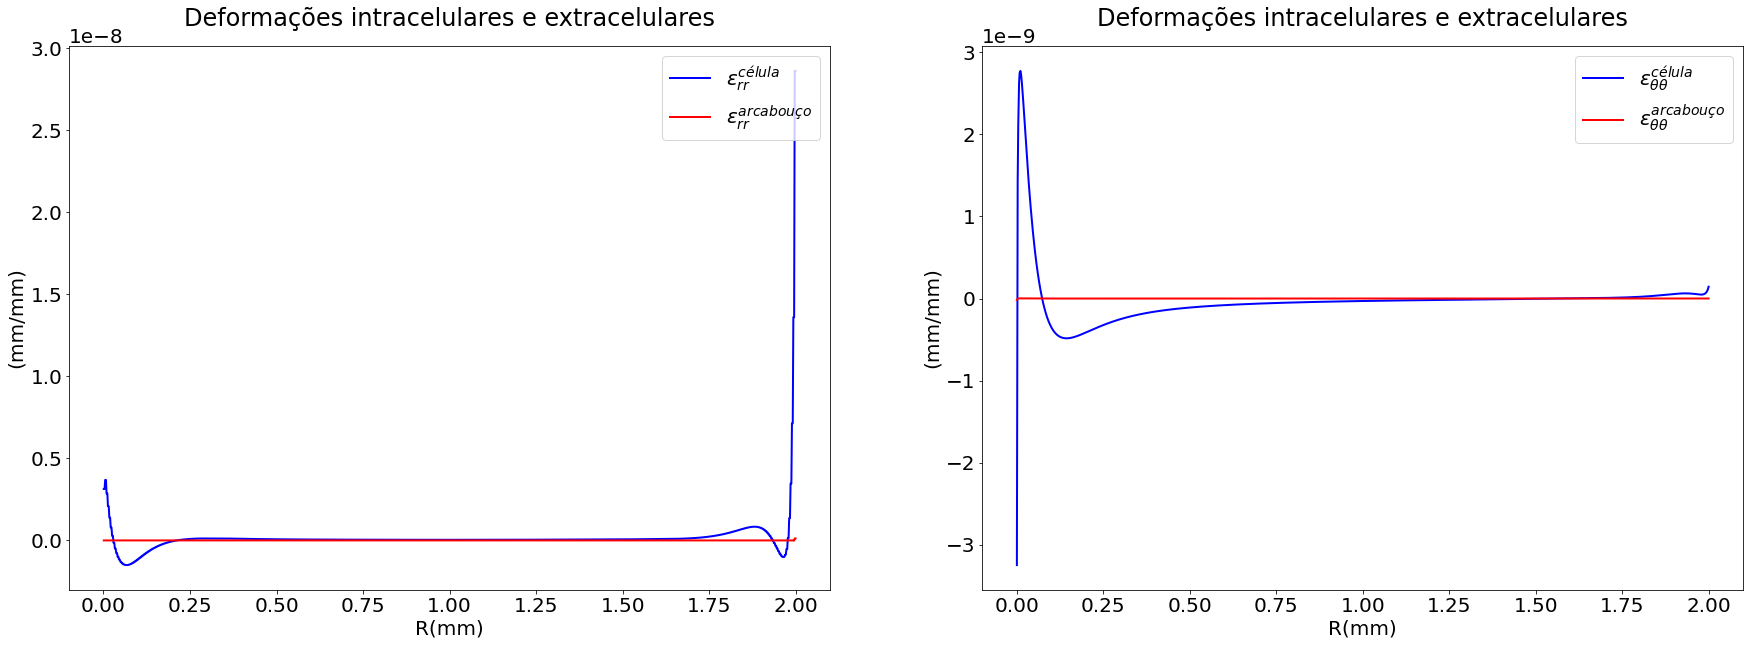

In [16]:
DEFORMACAO_ARCABOUCO_R = np.zeros (EL*2)
DEFORMACAO_ARCABOUCO_THETA = np.zeros (EL*2)
DEF_ARC_R_1 = DEFORMACAO_R_ELEMENTO [(ELEMENTO_LIMITE_TIPO[0] - linha * EL ):\
                              ((ELEMENTO_LIMITE_TIPO[0] - (linha - 1) * EL) )][:, 3]
DEF_ARC_R_2 = DEFORMACAO_R_ELEMENTO [(ELEMENTO_LIMITE_TIPO[0] - linha * EL ):\
                              ((ELEMENTO_LIMITE_TIPO[0] - (linha - 1) * EL) )][:, 2]
DEF_ARC_THETA_1 = DEFORMACAO_THETA_ELEMENTO [(ELEMENTO_LIMITE_TIPO[0] - linha * EL ):\
                              ((ELEMENTO_LIMITE_TIPO[0] - (linha - 1) * EL) )][:, 3]
DEF_ARC_THETA_2 = DEFORMACAO_THETA_ELEMENTO [(ELEMENTO_LIMITE_TIPO[0] - linha * EL ):\
                              ((ELEMENTO_LIMITE_TIPO[0] - (linha - 1) * EL) )][:, 2]
contador = 0
for i in range(0, 2 * EL, 2):
  DEFORMACAO_ARCABOUCO_R [ i ] = DEF_ARC_R_1 [ contador ] 
  DEFORMACAO_ARCABOUCO_R [ i + 1] = DEF_ARC_R_2 [ contador ]
  DEFORMACAO_ARCABOUCO_THETA [ i ] = DEF_ARC_THETA_1 [ contador ] 
  DEFORMACAO_ARCABOUCO_THETA [ i + 1] = DEF_ARC_THETA_2 [ contador ]
  contador += 1
linha -= 1
DEFORMACAO_CELULA_R = np.reshape ( DEFORMACAO_R_ELEMENTO [(ELEMENTO_LIMITE_TIPO[1] + linha * EL ):\
                              ((ELEMENTO_LIMITE_TIPO[1] + (linha + 1) * EL) )][:, 0:2], 2 * EL)
DEFORMACAO_CELULA_THETA = np.reshape ( DEFORMACAO_THETA_ELEMENTO [(ELEMENTO_LIMITE_TIPO[1] + linha * EL ):\
                              ((ELEMENTO_LIMITE_TIPO[1] + (linha + 1) * EL))][:, 0:2], 2 * EL)
linha += 1
figura_deformacao = plt.figure (figsize=(30,10))
deformacao_auddya_r = figura_deformacao.add_subplot ( 121 )
deformacao_auddya_r.plot ( X_TENSAO_DEFORMACAO , DEFORMACAO_CELULA_R, c = 'b' , linewidth = 2, linestyle = '-', \
                        label = r"$\epsilon^{célula}_{rr}$"  )
deformacao_auddya_r.plot ( X_TENSAO_DEFORMACAO , DEFORMACAO_ARCABOUCO_R, c = 'r' , lw = 2, ls = '-' , \
                        label = r"$\epsilon^{arcabouço}_{rr}$"  )
deformacao_auddya_r.legend ( loc = "upper right" )
deformacao_auddya_r.set_title ("Deformações intracelulares e extracelulares")
deformacao_auddya_r.set_xlabel ( "R(mm)" )
deformacao_auddya_r.set_ylabel ( "(mm/mm)" )

deformacao_auddya_t = figura_deformacao.add_subplot ( 122 )
deformacao_auddya_t.plot ( X_TENSAO_DEFORMACAO , DEFORMACAO_CELULA_THETA, c = 'b' , linewidth = 2, linestyle = '-', \
                        label = r"$\epsilon^{célula}_{\theta\theta}$"  )
deformacao_auddya_t.plot ( X_TENSAO_DEFORMACAO , DEFORMACAO_ARCABOUCO_THETA, c = 'r' , lw = 2, ls = '-' , \
                        label = r"$\epsilon^{arcabouço}_{\theta\theta}$"  )
deformacao_auddya_t.legend ( loc = "upper right" )
deformacao_auddya_t.set_title ("Deformações intracelulares e extracelulares")
deformacao_auddya_t.set_xlabel ( "R(mm)" )
deformacao_auddya_t.set_ylabel ( "(mm/mm)" )
plt.show()

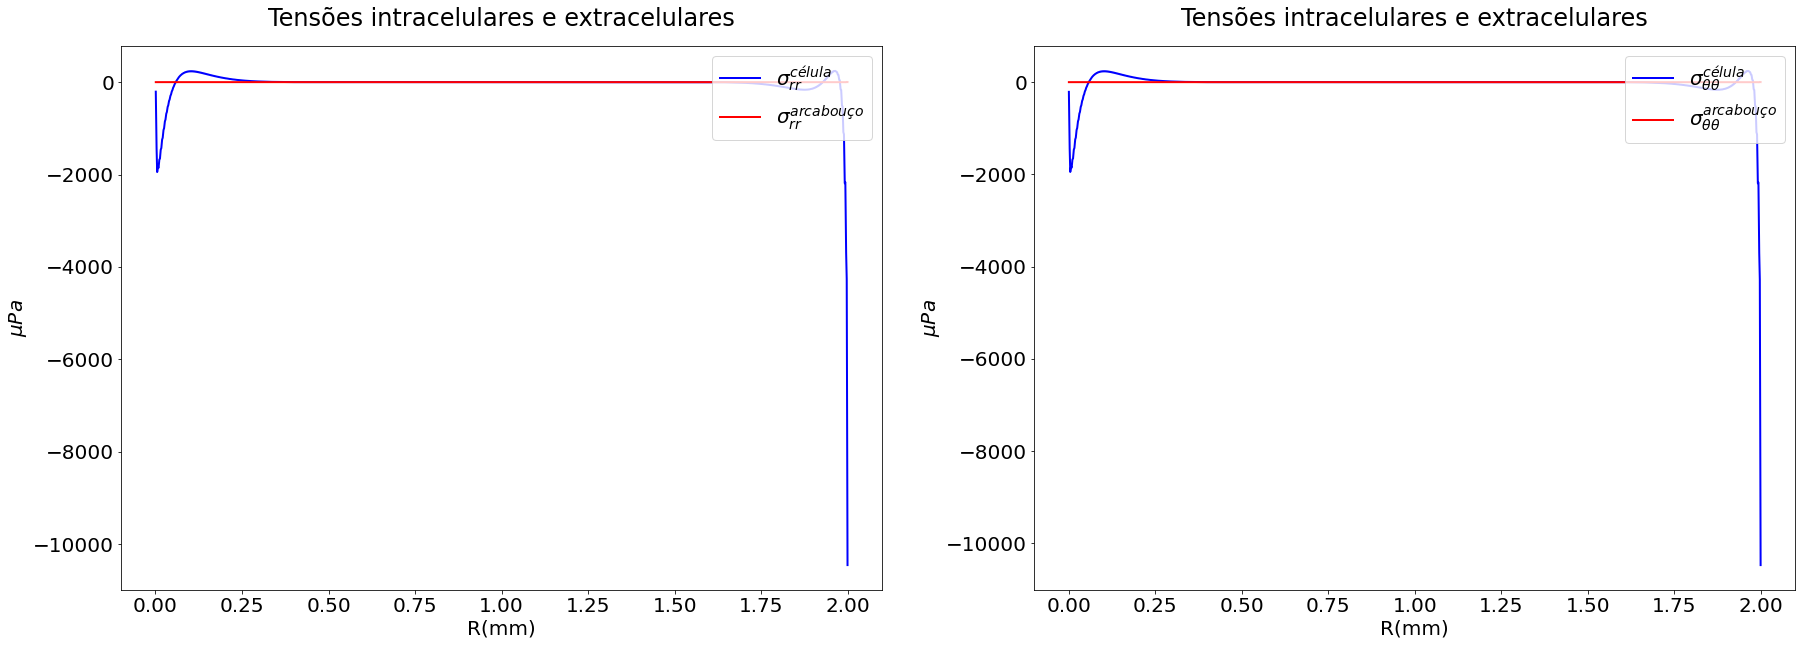

In [17]:
TENSAO_ARCABOUCO_R = np.zeros (EL*2)
TENSAO_ARCABOUCO_THETA = np.zeros (EL*2)
TEN_ARC_R_1 = TENSAO_R_ELEMENTO [(ELEMENTO_LIMITE_TIPO[0] - linha * EL ):\
                              ((ELEMENTO_LIMITE_TIPO[0] - (linha - 1) * EL) )][:, 3]
TEN_ARC_R_2 = TENSAO_R_ELEMENTO [(ELEMENTO_LIMITE_TIPO[0] - linha * EL ):\
                              ((ELEMENTO_LIMITE_TIPO[0] - (linha - 1) * EL) )][:, 2]
TEN_ARC_THETA_1 = TENSAO_THETA_ELEMENTO [(ELEMENTO_LIMITE_TIPO[0] - linha * EL ):\
                              ((ELEMENTO_LIMITE_TIPO[0] - (linha - 1) * EL) )][:, 3]
TEN_ARC_THETA_2 = TENSAO_THETA_ELEMENTO [(ELEMENTO_LIMITE_TIPO[0] - linha * EL ):\
                              ((ELEMENTO_LIMITE_TIPO[0] - (linha - 1) * EL) )][:, 2]
contador = 0
for i in range(0, 2 * EL, 2):
  TENSAO_ARCABOUCO_R [ i ] = TEN_ARC_R_1 [ contador ] 
  TENSAO_ARCABOUCO_R [ i + 1] = TEN_ARC_R_2 [ contador ]
  TENSAO_ARCABOUCO_THETA [ i ] = TEN_ARC_THETA_1 [ contador ] 
  TENSAO_ARCABOUCO_THETA [ i + 1] = TEN_ARC_THETA_2 [ contador ]
  contador += 1
linha -= 1
TENSAO_CELULA_R = np.reshape ( TENSAO_R_ELEMENTO [(ELEMENTO_LIMITE_TIPO[1] + linha * EL ):\
                              ((ELEMENTO_LIMITE_TIPO[1] + (linha + 1) * EL) )][:, 0:2], 2 * EL)
TENSAO_CELULA_THETA = np.reshape ( TENSAO_THETA_ELEMENTO [(ELEMENTO_LIMITE_TIPO[1] + linha * EL ):\
                              ((ELEMENTO_LIMITE_TIPO[1] + (linha + 1) * EL))][:, 0:2], 2 * EL)
linha += 1
figura_tensao = plt.figure (figsize=(30,10))

tensao_auddya_r = figura_tensao.add_subplot ( 121 )

tensao_auddya_r.plot ( X_TENSAO_DEFORMACAO , TENSAO_CELULA_R, c = 'b' , linewidth = 2, linestyle = '-', \
                        label = r"$\sigma^{célula}_{rr}$"  )
tensao_auddya_r.plot ( X_TENSAO_DEFORMACAO , TENSAO_ARCABOUCO_R, c = 'r' , lw = 2, ls = '-' , \
                        label = r"$\sigma^{arcabouço}_{rr}$"  )
tensao_auddya_r.legend ( loc = "upper right" )
tensao_auddya_r.set_title ("Tensões intracelulares e extracelulares")
tensao_auddya_r.set_xlabel ( "R(mm)" )
tensao_auddya_r.set_ylabel ( "$\mu Pa$")

tensao_auddya_t = figura_tensao.add_subplot ( 122 )
tensao_auddya_t.plot ( X_TENSAO_DEFORMACAO , TENSAO_CELULA_THETA, c = 'b' , linewidth = 2, linestyle = '-', \
                        label = r"$\sigma^{célula}_{\theta\theta}$"  )
tensao_auddya_t.plot ( X_TENSAO_DEFORMACAO , TENSAO_ARCABOUCO_THETA, c = 'r' , lw = 2, ls = '-' , \
                        label = r"$\sigma^{arcabouço}_{\theta\theta}$"  )
tensao_auddya_t.legend ( loc = "upper right" )
tensao_auddya_t.set_title ("Tensões intracelulares e extracelulares")
tensao_auddya_t.set_xlabel ( "R(mm)" )
tensao_auddya_t.set_ylabel ( "$\mu Pa$")
plt.show()